<a href="https://colab.research.google.com/github/debi201326/SAR-Flood-Detection/blob/main/sar_flood_unet_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import cv2
import math
import time
import random
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import torchvision.transforms.functional as TF
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode

In [ ]:
DATA_ROOT = "/kaggle/input/flood-detect-data"  # change if needed
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 20
IMG_SIZE = (256, 256)
CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

In [ ]:
def lee_filter(img, size=5, eps=1e-8):
    img = img.astype(np.float32)
    mean = cv2.blur(img, (size, size))
    mean_sq = cv2.blur(img**2, (size, size))
    variance = mean_sq - mean**2
    overall_variance = variance.mean()
    weight = variance / (variance + overall_variance + eps)
    weight = np.clip(weight, 0, 1)
    filtered = mean + weight * (img - mean)
    filtered = np.clip(filtered, 0, 255)
    return np.uint8(filtered)

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', s)]

In [ ]:
class JointTransform:
    def __init__(self, size=(256,256), hflip_prob=0.5, vflip_prob=0.0, rot_deg=10):
        self.size = size
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.rot_deg = rot_deg

    def __call__(self, img_pil, mask_pil):
        # Resize (use interpolation keyword)
        img = img_pil.resize(self.size, resample=Image.BILINEAR)
        mask = mask_pil.resize(self.size, resample=Image.NEAREST)

        # Random flips/rotation
        if random.random() < self.hflip_prob:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
        if random.random() < self.vflip_prob:
            img = TF.vflip(img)
            mask = TF.vflip(mask)
        if self.rot_deg > 0:
            angle = random.uniform(-self.rot_deg, self.rot_deg)
            img = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST)

        # To tensor
        img_t = TF.to_tensor(img)
        mask_t = TF.to_tensor(mask)
        mask_t = (mask_t > 0.5).float()
        return img_t, mask_t

In [ ]:
class SARFloodDataset(Dataset):
    def __init__(self, root_dir, transform=None, apply_lee=True):
        self.A_paths = sorted(glob(os.path.join(root_dir, "A", "*.png")), key=natural_sort_key)
        self.B_paths = sorted(glob(os.path.join(root_dir, "B", "*.png")), key=natural_sort_key)
        self.label_paths = sorted(glob(os.path.join(root_dir, "Label", "*.png")), key=natural_sort_key)
        self.transform = transform
        self.apply_lee = apply_lee
        assert len(self.A_paths) == len(self.B_paths) == len(self.label_paths), "Unequal dataset counts"

    def __len__(self):
        return len(self.label_paths)

    def __getitem__(self, idx):
        A = cv2.imread(self.A_paths[idx], cv2.IMREAD_GRAYSCALE)
        B = cv2.imread(self.B_paths[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.label_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.apply_lee:
            A = lee_filter(A)
            B = lee_filter(B)

        # Make a 3-channel canvas so PIL can handle easily: (A,B,0)
        H, W = A.shape
        canvas = np.zeros((H, W, 3), dtype=np.uint8)
        canvas[..., 0] = A
        canvas[..., 1] = B
        canvas[..., 2] = 0
        img_pil = Image.fromarray(canvas)
        mask_pil = Image.fromarray(label)

        if self.transform:
            img_t, mask_t = self.transform(img_pil, mask_pil)
        else:
            img_t = TF.to_tensor(img_pil)
            mask_t = TF.to_tensor(mask_pil)
            mask_t = (mask_t > 0.5).float()

        # Convert to 2 channels by taking first two channels
        img_t = img_t[:2, :, :]  # C=2, H, W
        return img_t, mask_t


In [ ]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


In [ ]:
def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

class UpConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
    def forward(self, x): return self.up(x)


In [ ]:
class AttnUNetResNet34(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, pretrained=True):
        super(AttnUNetResNet34, self).__init__()

        # Load pretrained ResNet34 in a way compatible with different torchvision versions
        try:
            # newer torchvision (>0.13) uses weights=...
            resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None)
        except Exception:
            # fallback to older API
            resnet = models.resnet34(pretrained=pretrained)

        # Modify the first conv to accept in_channels (2) instead of 3
        orig_conv = resnet.conv1  # (64,3,7,7)
        new_conv = nn.Conv2d(in_channels, orig_conv.out_channels, kernel_size=orig_conv.kernel_size,
                             stride=orig_conv.stride, padding=orig_conv.padding, bias=(orig_conv.bias is not None))

        if pretrained:
            with torch.no_grad():
                w = orig_conv.weight.data  # (64,3,7,7)
                # initialize new conv weights using the first two channels of pretrained weights
                # and scale to keep magnitude similar (simple but effective)
                if w.shape[1] >= in_channels:
                    new_w = w[:, :in_channels, :, :].clone()
                else:
                    # rare case: pretrained conv has fewer channels (unlikely) -> tile/average
                    new_w = torch.zeros((w.shape[0], in_channels, w.shape[2], w.shape[3]), dtype=w.dtype)
                    for c in range(in_channels):
                        new_w[:, c, :, :] = w[:, c % w.shape[1], :, :]
                new_conv.weight.data = new_w.clone()
                if orig_conv.bias is not None:
                    new_conv.bias.data = orig_conv.bias.data.clone()
        else:
            nn.init.kaiming_normal_(new_conv.weight, mode='fan_out', nonlinearity='relu')

        # Encoder (using modified resnet conv)
        self.conv1 = nn.Sequential(new_conv, resnet.bn1, resnet.relu)  # output: 64
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1  # 64
        self.layer2 = resnet.layer2  # 128
        self.layer3 = resnet.layer3  # 256
        self.layer4 = resnet.layer4  # 512

        # Decoder
        self.up4 = UpConv(512, 256)
        self.att4 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.dec4 = conv_block(512, 256)

        self.up3 = UpConv(256, 128)
        self.att3 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.dec3 = conv_block(256, 128)

        self.up2 = UpConv(128, 64)
        self.att2 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec2 = conv_block(128, 64)

        self.up1 = UpConv(64, 64)
        # for the last connection, we'll use features before pool (conv1 output)
        self.att1 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (B,2,H,W)
        x1 = self.conv1(x)        # 64 channels, half-res due to stride
        x_pool = self.maxpool(x1) # downsample
        x2 = self.layer1(x_pool)  # 64
        x3 = self.layer2(x2)      # 128
        x4 = self.layer3(x3)      # 256
        x5 = self.layer4(x4)      # 512

        # Decoder + Attention
        d4 = self.up4(x5)  # ->256
        x4_att = self.att4(g=d4, x=x4)
        d4 = torch.cat([d4, x4_att], dim=1)  # 512
        d4 = self.dec4(d4)  # 256

        d3 = self.up3(d4)  # ->128
        x3_att = self.att3(g=d3, x=x3)
        d3 = torch.cat([d3, x3_att], dim=1)
        d3 = self.dec3(d3)  # 128

        d2 = self.up2(d3)  # ->64
        x2_att = self.att2(g=d2, x=x2)
        d2 = torch.cat([d2, x2_att], dim=1)
        d2 = self.dec2(d2)  # 64

        d1 = self.up1(d2)  # ->64
        x1_att = self.att1(g=d1, x=x1)
        # If spatial mismatch happens (rare), center crop to match before concat
        if d1.shape[2:] != x1_att.shape[2:]:
            # simple center crop x1_att to d1 size
            _, _, h_d, w_d = d1.shape
            _, _, h_x, w_x = x1_att.shape
            start_h = (h_x - h_d) // 2
            start_w = (w_x - w_d) // 2
            x1_att = x1_att[:, :, start_h:start_h+h_d, start_w:start_w+w_d]
        d1 = torch.cat([d1, x1_att], dim=1)
        d1 = self.dec1(d1)  # 64

        out = self.final_conv(d1)  # logits
        return out


In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        # logits: (B,1,H,W)   targets: (B,1,H,W)
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)
        intersection = (probs_flat * targets_flat).sum(dim=1)
        smooth = 1e-6
        dice_score = (2. * intersection + smooth) / (probs_flat.sum(dim=1) + targets_flat.sum(dim=1) + smooth)
        dice_loss = 1 - dice_score.mean()
        return self.bce_weight * bce_loss + (1.0 - self.bce_weight) * dice_loss

def dice_coeff(logits, targets, threshold=0.5, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    num = 2 * (preds * targets).sum(dim=(1,2,3))
    den = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + eps
    return (num / den).mean().item()

def iou_score(logits, targets, threshold=0.5, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - inter + eps
    return ( (inter + eps) / union ).mean().item()

In [ ]:
class GradCAM:
    def __init__(self, model, target_module):
        self.model = model
        self.target_module = target_module
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        # forward hook
        def forward_hook(module, inp, out):
            # store activations (detach to avoid extra graph)
            self.activations = out.detach()

        # backward hook - use register_full_backward_hook if available (recommended)
        def backward_hook(module, grad_in, grad_out):
            # grad_out is a tuple; gradient wrt module output is grad_out[0]
            self.gradients = grad_out[0].detach()

        self.target_module.register_forward_hook(forward_hook)
        # prefer full backward hook, fallback to backward hook
        if hasattr(self.target_module, "register_full_backward_hook"):
            self.target_module.register_full_backward_hook(lambda m, gi, go: backward_hook(m, gi, go))
        else:
            # older pytorch
            self.target_module.register_backward_hook(lambda m, gi, go: backward_hook(m, gi, go))

    def generate_cam(self, input_tensor, target_mask=None, upsample_size=None):
        """
        input_tensor: (1, C, H, W)
        target_mask: optional (1,1,H,W) or (H,W) numpy
        upsample_size: tuple (H_out, W_out)
        returns: CAM 2D numpy array of shape upsample_size or original activation spatial size
        """
        self.model.eval()
        # ensure previous gradients cleared
        self.model.zero_grad()
        logits = self.model(input_tensor)  # (1,1,H,W) logits
        # If a target_mask provided, compute scalar = mean(logits * mask), else mean of logits
        if target_mask is None:
            loss = logits.mean()
        else:
            if isinstance(target_mask, np.ndarray):
                t = torch.from_numpy(target_mask).unsqueeze(0).unsqueeze(0).to(logits.device).float()
            else:
                t = target_mask.to(logits.device).float()
            # ensure t shape matches logits spatial dims (may need resize outside)
            if t.shape != logits.shape:
                t = F.interpolate(t, size=logits.shape[2:], mode='bilinear', align_corners=False)
            loss = (logits * t).mean()
        loss.backward(retain_graph=True)

        grads = self.gradients  # (1, C, h, w)
        acts = self.activations  # (1, C, h, w)
        # global average pooling on gradients
        weights = torch.mean(grads, dim=(2,3), keepdim=True)  # (1, C, 1, 1)
        cam = torch.sum(weights * acts, dim=1, keepdim=True)  # (1,1,h,w)
        cam = F.relu(cam)
        cam = cam.detach().cpu().numpy()[0,0]  # (h,w)

        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        if upsample_size is not None:
            cam_resized = cv2.resize(cam, (int(upsample_size[1]), int(upsample_size[0])), interpolation=cv2.INTER_LINEAR)
            return cam_resized
        else:
            return cam


In [ ]:
joint_transform = JointTransform(size=IMG_SIZE, hflip_prob=0.5, rot_deg=10)
full_dataset = SARFloodDataset(root_dir=DATA_ROOT, transform=joint_transform, apply_lee=True)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size],
                                         generator=torch.Generator().manual_seed(SEED))

# It's sometimes safer to set num_workers=0 in notebooks / kaggle environments; keep 2 if you know it's safe.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset samples: {len(full_dataset)} | Train: {len(train_dataset)} | Val: {len(val_dataset)}")
print("Device:", DEVICE)

model = AttnUNetResNet34(in_channels=2, out_channels=1, pretrained=True).to(DEVICE)
criterion = DiceBCELoss(bce_weight=0.6).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)

Dataset samples: 5360 | Train: 4288 | Val: 1072
Device: cuda


In [ ]:
def evaluate(model, loader):
    model.eval()
    losses, dices, ious = [], [], []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = model(imgs)

            # --- Resize masks if needed ---
            if masks.shape != logits.shape:
                masks = F.interpolate(masks, size=logits.shape[2:], mode='bilinear', align_corners=False)
            # ------------------------------

            loss = criterion(logits, masks)
            losses.append(loss.item())
            dices.append(dice_coeff(logits, masks))
            ious.append(iou_score(logits, masks))
    return np.mean(losses), np.mean(dices), np.mean(ious)


# ===================== TRAINING LOOP =====================

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)

    for step, (imgs, masks) in enumerate(loop):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        logits = model(imgs)

        # --- Resize masks if needed ---
        if masks.shape != logits.shape:
            masks = F.interpolate(masks, size=logits.shape[2:], mode='bilinear', align_corners=False)
        # ------------------------------

        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=running_loss / (step + 1))

    train_loss = running_loss / len(train_loader)
    val_loss, val_dice, val_iou = evaluate(model, val_loader)
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_dice"].append(val_dice)
    history["val_iou"].append(val_iou)

    print(f"Epoch {epoch}/{EPOCHS} -> Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        ckpt = os.path.join(CHECKPOINT_DIR, f"attnresnet_best_epoch{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "val_loss": val_loss
        }, ckpt)
        print("Saved checkpoint:", ckpt)

Epoch 1/20:  31%|███       | 328/1072 [00:33<00:52, 14.15it/s, loss=0.387]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0c33da4ae0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d0c33da4ae0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
            ^ ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/pyth

Epoch 1/20 -> Train Loss: 0.2934 | Val Loss: 0.1824 | Val Dice: 0.8655 | Val IoU: 0.7846
Saved checkpoint: ./checkpoints/attnresnet_best_epoch1.pth


Epoch 2/20 -> Train Loss: 0.1745 | Val Loss: 0.1363 | Val Dice: 0.8875 | Val IoU: 0.8137
Saved checkpoint: ./checkpoints/attnresnet_best_epoch2.pth


Epoch 3/20 -> Train Loss: 0.1455 | Val Loss: 0.1264 | Val Dice: 0.8908 | Val IoU: 0.8181
Saved checkpoint: ./checkpoints/attnresnet_best_epoch3.pth


Epoch 4/20 -> Train Loss: 0.1289 | Val Loss: 0.1137 | Val Dice: 0.8947 | Val IoU: 0.8248
Saved checkpoint: ./checkpoints/attnresnet_best_epoch4.pth


Epoch 5/20 -> Train Loss: 0.1256 | Val Loss: 0.1146 | Val Dice: 0.8968 | Val IoU: 0.8274


Epoch 6/20 -> Train Loss: 0.1211 | Val Loss: 0.1262 | Val Dice: 0.8876 | Val IoU: 0.8138


Epoch 7/20 -> Train Loss: 0.1154 | Val Loss: 0.1098 | Val Dice: 0.9004 | Val IoU: 0.8330
Saved checkpoint: ./checkpoints/attnresnet_best_epoch7.pth


Epoch 8/20 -> Train Loss: 0.1166 | Val Loss: 0.1072 | Val Dice: 0.9023 | Val IoU: 0.8357
Saved checkpoint: ./checkpoints/attnresnet_best_epoch8.pth


Epoch 9/20 -> Train Loss: 0.1109 | Val Loss: 0.1095 | Val Dice: 0.9003 | Val IoU: 0.8330


Epoch 10/20 -> Train Loss: 0.1114 | Val Loss: 0.1010 | Val Dice: 0.9069 | Val IoU: 0.8426
Saved checkpoint: ./checkpoints/attnresnet_best_epoch10.pth


Epoch 11/20 -> Train Loss: 0.1087 | Val Loss: 0.1005 | Val Dice: 0.9067 | Val IoU: 0.8418
Saved checkpoint: ./checkpoints/attnresnet_best_epoch11.pth


Epoch 12/20 -> Train Loss: 0.1076 | Val Loss: 0.1037 | Val Dice: 0.9042 | Val IoU: 0.8381


Epoch 13/20 -> Train Loss: 0.1071 | Val Loss: 0.0988 | Val Dice: 0.9088 | Val IoU: 0.8446
Saved checkpoint: ./checkpoints/attnresnet_best_epoch13.pth


Epoch 14/20 -> Train Loss: 0.1040 | Val Loss: 0.1020 | Val Dice: 0.9069 | Val IoU: 0.8409


Epoch 15/20:  80%|███████▉  | 855/1072 [01:01<00:15, 14.02it/s, loss=0.103]

Epoch 16/20 -> Train Loss: 0.1017 | Val Loss: 0.0980 | Val Dice: 0.9093 | Val IoU: 0.8460


Epoch 17/20 -> Train Loss: 0.1027 | Val Loss: 0.0963 | Val Dice: 0.9118 | Val IoU: 0.8494
Saved checkpoint: ./checkpoints/attnresnet_best_epoch17.pth


Epoch 18/20 -> Train Loss: 0.1010 | Val Loss: 0.0982 | Val Dice: 0.9108 | Val IoU: 0.8477


Epoch 19/20 -> Train Loss: 0.0983 | Val Loss: 0.1026 | Val Dice: 0.9066 | Val IoU: 0.8422


Epoch 20/20:  71%|███████   | 757/1072 [00:53<00:22, 14.16it/s, loss=0.0961]

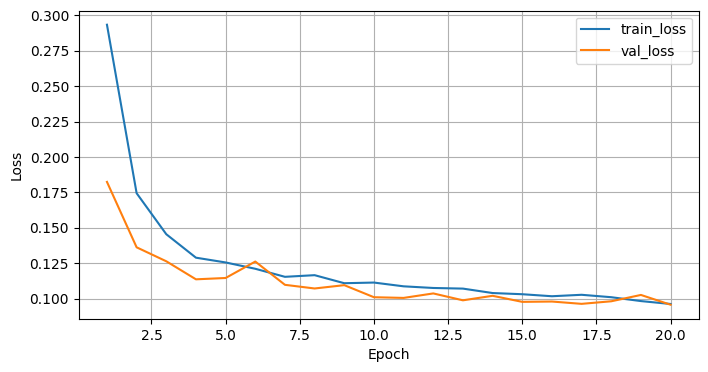

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(range(1, len(history["train_loss"])+1), history["train_loss"], label="train_loss")
plt.plot(range(1, len(history["val_loss"])+1), history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
plt.show()

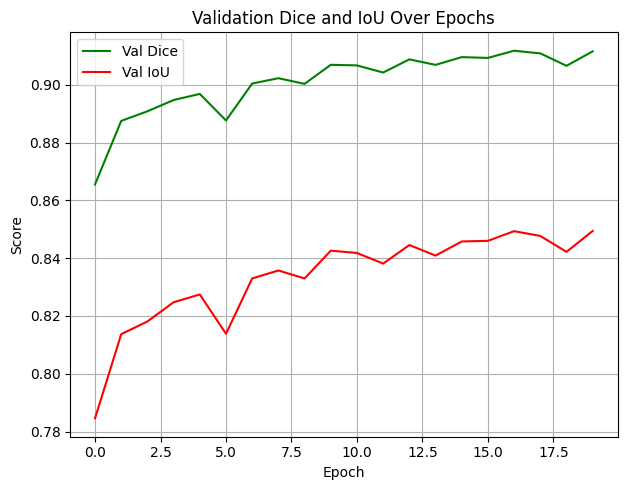

In [ ]:
plt.figure(figsize=(12,5))

# Dice Curve
plt.subplot(1,2,2)
plt.plot(history["val_dice"], label="Val Dice", color='green')
plt.plot(history["val_iou"], label="Val IoU", color='red')
plt.title("Validation Dice and IoU Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

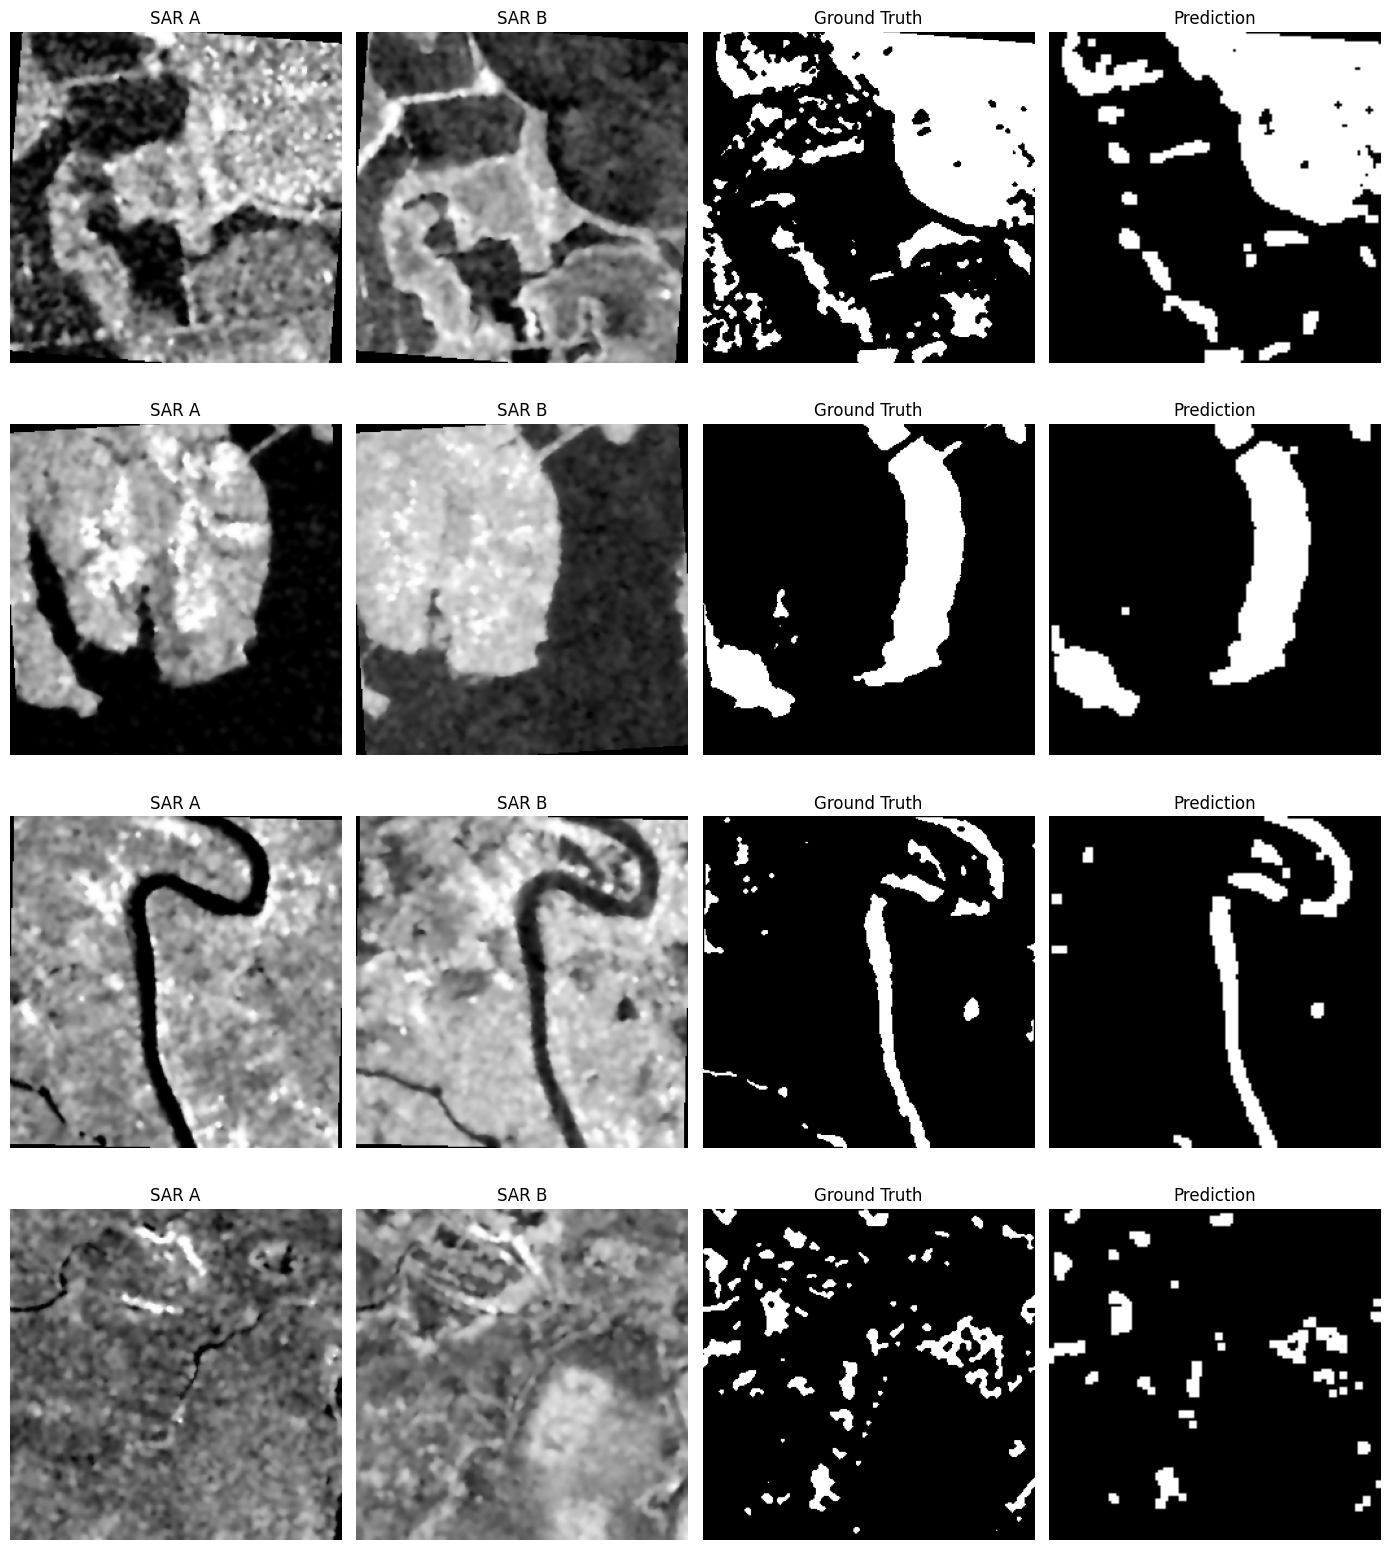

In [ ]:
def visualize_predictions(model, dataset, num_samples=4, threshold=0.5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(14, 4*num_samples))
    for i in range(num_samples):
        img, mask = dataset[i]
        img_in = img.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(img_in)
            probs = torch.sigmoid(logits).cpu().numpy()  # (1,1,H,W)
        probs = probs[0,0]  # HxW
        pred_mask = (probs > threshold).astype(np.uint8)
        # Postprocess small noise out
        kernel = np.ones((3,3), np.uint8)
        pred_mask = cv2.morphologyEx(pred_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
        img_np = img.permute(1,2,0).cpu().numpy()  # HxWx2
        sarA = img_np[:,:,0]; sarB = img_np[:,:,1]
        gt = mask.squeeze(0).cpu().numpy()
        axes[i,0].imshow(sarA, cmap='gray'); axes[i,0].set_title("SAR A"); axes[i,0].axis('off')
        axes[i,1].imshow(sarB, cmap='gray'); axes[i,1].set_title("SAR B"); axes[i,1].axis('off')
        axes[i,2].imshow(gt, cmap='gray'); axes[i,2].set_title("Ground Truth"); axes[i,2].axis('off')
        axes[i,3].imshow(pred_mask, cmap='gray'); axes[i,3].set_title("Prediction"); axes[i,3].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize some validation examples
if len(val_dataset) > 0:
    visualize_predictions(model, val_dataset, num_samples=min(4, len(val_dataset)))


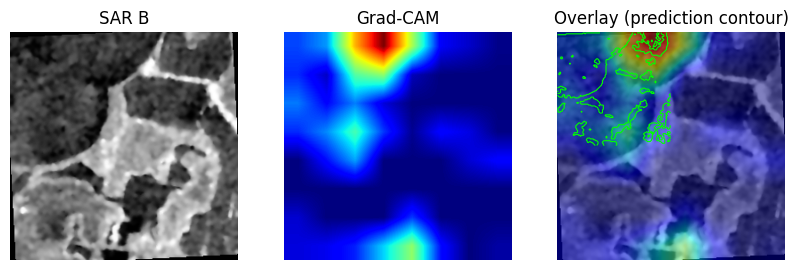

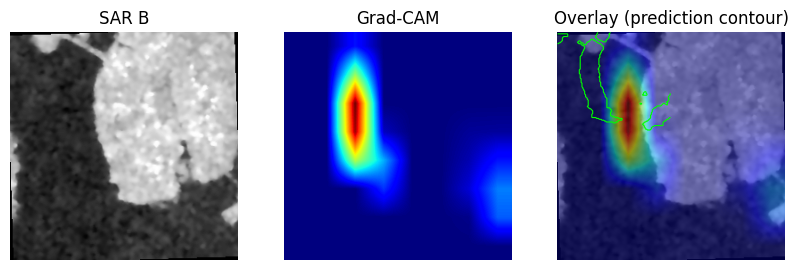

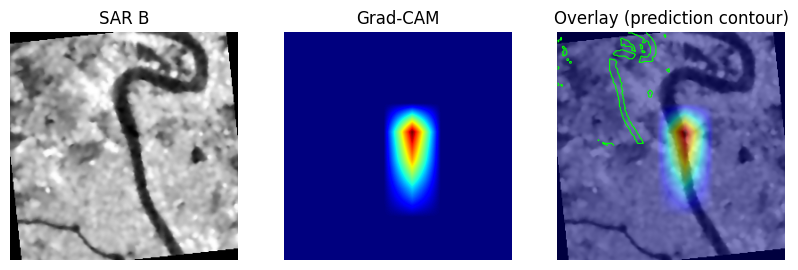

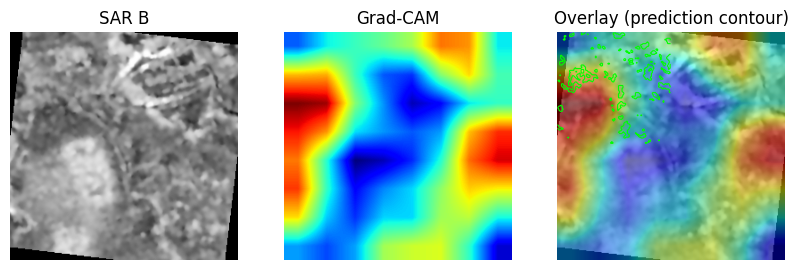

In [ ]:
target_module = None
try:
    target_module = model.layer4[-1].conv2
except Exception:
    target_module = model.layer4[-1]

gradcam = GradCAM(model, target_module)

def visualize_gradcam_on_sample(model, gradcam, dataset, idx=0, threshold=0.5):
    model.eval()
    img, mask = dataset[idx]
    img_in = img.unsqueeze(0).to(DEVICE)
    # Get CAM (resized to IMG_SIZE)
    cam = gradcam.generate_cam(img_in, target_mask=None, upsample_size=IMG_SIZE)  # HxW
    # Model prediction for overlay
    with torch.no_grad():
        logits = model(img_in)
        probs = torch.sigmoid(logits).cpu().numpy()[0,0]  # HxW
    pred_mask = (probs > threshold).astype(np.uint8)
    img_np = img.permute(1,2,0).cpu().numpy()
    sarB = img_np[:,:,1]  # choose second SAR channel for background
    # Plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(sarB, cmap='gray'); plt.title('SAR B'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(cam, cmap='jet'); plt.title('Grad-CAM'); plt.axis('off')
    # overlay
    plt.subplot(1,3,3); plt.imshow(sarB, cmap='gray'); plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.contour(pred_mask, colors='lime', linewidths=0.8, levels=[0.5])
    plt.title('Overlay (prediction contour)'); plt.axis('off')
    plt.show()

# Show Grad-CAM for first few val samples
for i in range(min(4, len(val_dataset))):
    visualize_gradcam_on_sample(model, gradcam, val_dataset, idx=i)


In [ ]:
final_path = os.path.join(CHECKPOINT_DIR, "attnresnet34_final.pth")
torch.save(model.state_dict(), final_path)
print("Saved final model to:", final_path)

Saved final model to: ./checkpoints/attnresnet34_final.pth


In [ ]:
model.eval()
val_loss, val_dice, val_iou = evaluate(model, val_loader)

print("\n========== Final Evaluation ==========")
print(f"Validation Loss : {val_loss:.4f}")
print(f"Dice Score      : {val_dice:.4f}")
print(f"IoU Score       : {val_iou:.4f}")
print("=====================================")



========== Final Evaluation ==========
Validation Loss : 0.0961
Dice Score      : 0.9111
IoU Score       : 0.8488
